<div align="center">
    <h1>Aprendizaje automático</h1>
    <h3>Fundamentos y aplicaciones en meteorología del espacio</h3>
    <h4>TP 1: Clasificación</h4>
     <h5>Alumno: Federico Iza</h5>
</div>

# Clasificación de CMEs

In [109]:
import pandas as pd
from tp1_radar_settings import *
import matplotlib.pyplot as plt
from utils.plot import config_plots
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers.core import Activation
from keras.layers.core import Dense
import tensorflow as tf

In [110]:
%matplotlib inline
config_plots()

## Adquisición de datos

In [111]:
df = pd.read_csv('../data/CMEs.csv')
df.rename(columns={'vprop': 'Velocity'}, inplace=True)

In [112]:
df.head()

,SunActivity,Velocity,Origin
0,low,592,flare
1,low,355,flare
2,low,619,flare
3,high,309,flare
4,high,1557,flare


Estos datos sugieren un problema que puede perjudicar el entranamiento del modelo. La variable `SunActivity` tiene valores binarios que indican si la actividad solar fue alta o baja. Sin embargo, esto podría no ser suficiente a la hora de entrenar el modelo y sería mejor contar con una variable numérica que indique el nivel de actividad solar con mayor precisión.

Otro problema que puede nacer de estos datos es la cantidad. Se cuenta en total con 65 datos. Sin embargo, esta cantidad se deduce al considerar la separación entre datos de entrenamiento y de prueba, por lo que el número final puede ser pequeño para lograr un entrenamiento satisfactorio del modelo.

## Preprocesamiento de datos

Se asigna 0 a baja intensidad solar y 1 a alta intensidad solar; por otro lado, se asigna al origen un 1 si es *flare* y 0 si no lo es.

In [113]:
# Numerical data has to be used in ANNs
numerical_origin = {'flare': 1, 'no flare': 0}
df['Origin'] = df['Origin'].map(numerical_origin)

numerical_activity = {'low': 0, 'high': 1}
df['SunActivity'] = df['SunActivity'].map(numerical_activity)

In [114]:
df.head()

,SunActivity,Velocity,Origin
0,0,592,1
1,0,355,1
2,0,619,1
3,1,309,1
4,1,1557,1


Chequeo si hay datos inválidos en el dataset:

In [115]:
np.sum(df == np.nan)

SunActivity    0
Velocity       0
Origin         0
dtype: int64

## Ingeniería de datos

### Balaceo de datos

In [116]:
data_balace = df['Origin'].value_counts()
print(data_balace)

1    39
0    26
Name: Origin, dtype: int64


In [117]:
# Remove data to balance dataset
counter = 13  # Remove the first 99 rows with target=1
df_aux = pd.DataFrame()
for idx, row in df.iterrows():
    if counter > 0:
        if row['Origin'] == 1:
            counter -= 1
        else:
            df_aux = pd.concat([df_aux, pd.DataFrame(row).T],
                               axis=0,
                               ignore_index=True)
    else:
        df_aux = pd.concat([df_aux, pd.DataFrame(row).T],
                           axis=0,
                           ignore_index=True)

In [118]:
data_balace = df_aux['Origin'].value_counts()
print(data_balace)

1    26
0    26
Name: Origin, dtype: int64


In [119]:
df_aux.head()

,SunActivity,Velocity,Origin
0,0,1968,1
1,0,1173,1
2,0,1600,1
3,0,1089,1
4,0,453,1


## Preparación de datos

In [120]:
features = df_aux.loc[:, df_aux.columns != 'Origin'].copy()
target =  df_aux.loc[:, df_aux.columns == 'Origin'].copy()

In [121]:
(feats_train, feats_test,
 target_train, target_test) = train_test_split(features, target,
                                               test_size=TEST_SIZE)

### Escalado de datos

In [122]:
scaler = MinMaxScaler()
feats_train.loc[:, 'Velocity'] = scaler.fit_transform(
    np.array(feats_train['Velocity']).reshape(-1, 1))

In [123]:
feats_train

,SunActivity,Velocity
42,1,0.168203
15,0,0.014977
8,1,0.184332
25,1,0.347926
24,1,0.256336
0,0,1.000000
47,1,0.059908
30,0,0.000000
31,0,0.074885
32,1,0.189516


In [124]:
feats_test['Velocity'] = scaler.transform(
    np.array(feats_test['Velocity']).reshape(-1, 1))

In [125]:
feats_test

,SunActivity,Velocity
38,1,0.465438
44,1,0.297235
4,0,0.127304
19,1,0.102535
34,1,0.083525
36,1,0.252880
17,1,0.040323
10,1,0.626152
16,1,0.166475
22,0,0.149194


## Modelado

In [126]:
input_size = feats_train.shape[1]  # Number of feats for training
print(input_size)

2


In [127]:
# Define ANN architecture
models = []

for i in range(len(models_params.keys())):
    # Instance the model
    model = Sequential()

    for j in range(models_params[f'm{i}']['N_LAYERS']):
        model.add(Dense(units=models_params[f'm{i}']['N_NEURONS'][j],
                        input_dim=input_size))
        model.add(Activation(models_params[f'm{i}']['ACTIVATION_FUNCTIONS'][j]))

    # Complile model
    model.compile(loss=LOSS_FUNCTION,  # Select loss function
                  optimizer=OPTIMIZER,  # Select optimizer
                  metrics=[tf.keras.metrics.Accuracy()])

    # Append model to list of models
    models.append(model)

In [128]:
histories = []
for i in range(len(models_params.keys())):
    history = models[i].fit(feats_train, target_train,
                            epochs=models_params[f'm{i}']['N_EPOCHS'],
                            validation_split=VALIDATION_SPLIT,
                            verbose=0)
    histories.append(history)

In [129]:
# Calculate the upper limit of the x-axis
xmax = models_params['m0']['N_EPOCHS']
for i in range(len(models_params.keys())):
    if models_params[f'm{i}']['N_EPOCHS'] > xmax:
        xmax = models_params[f'm{i}']['N_EPOCHS']

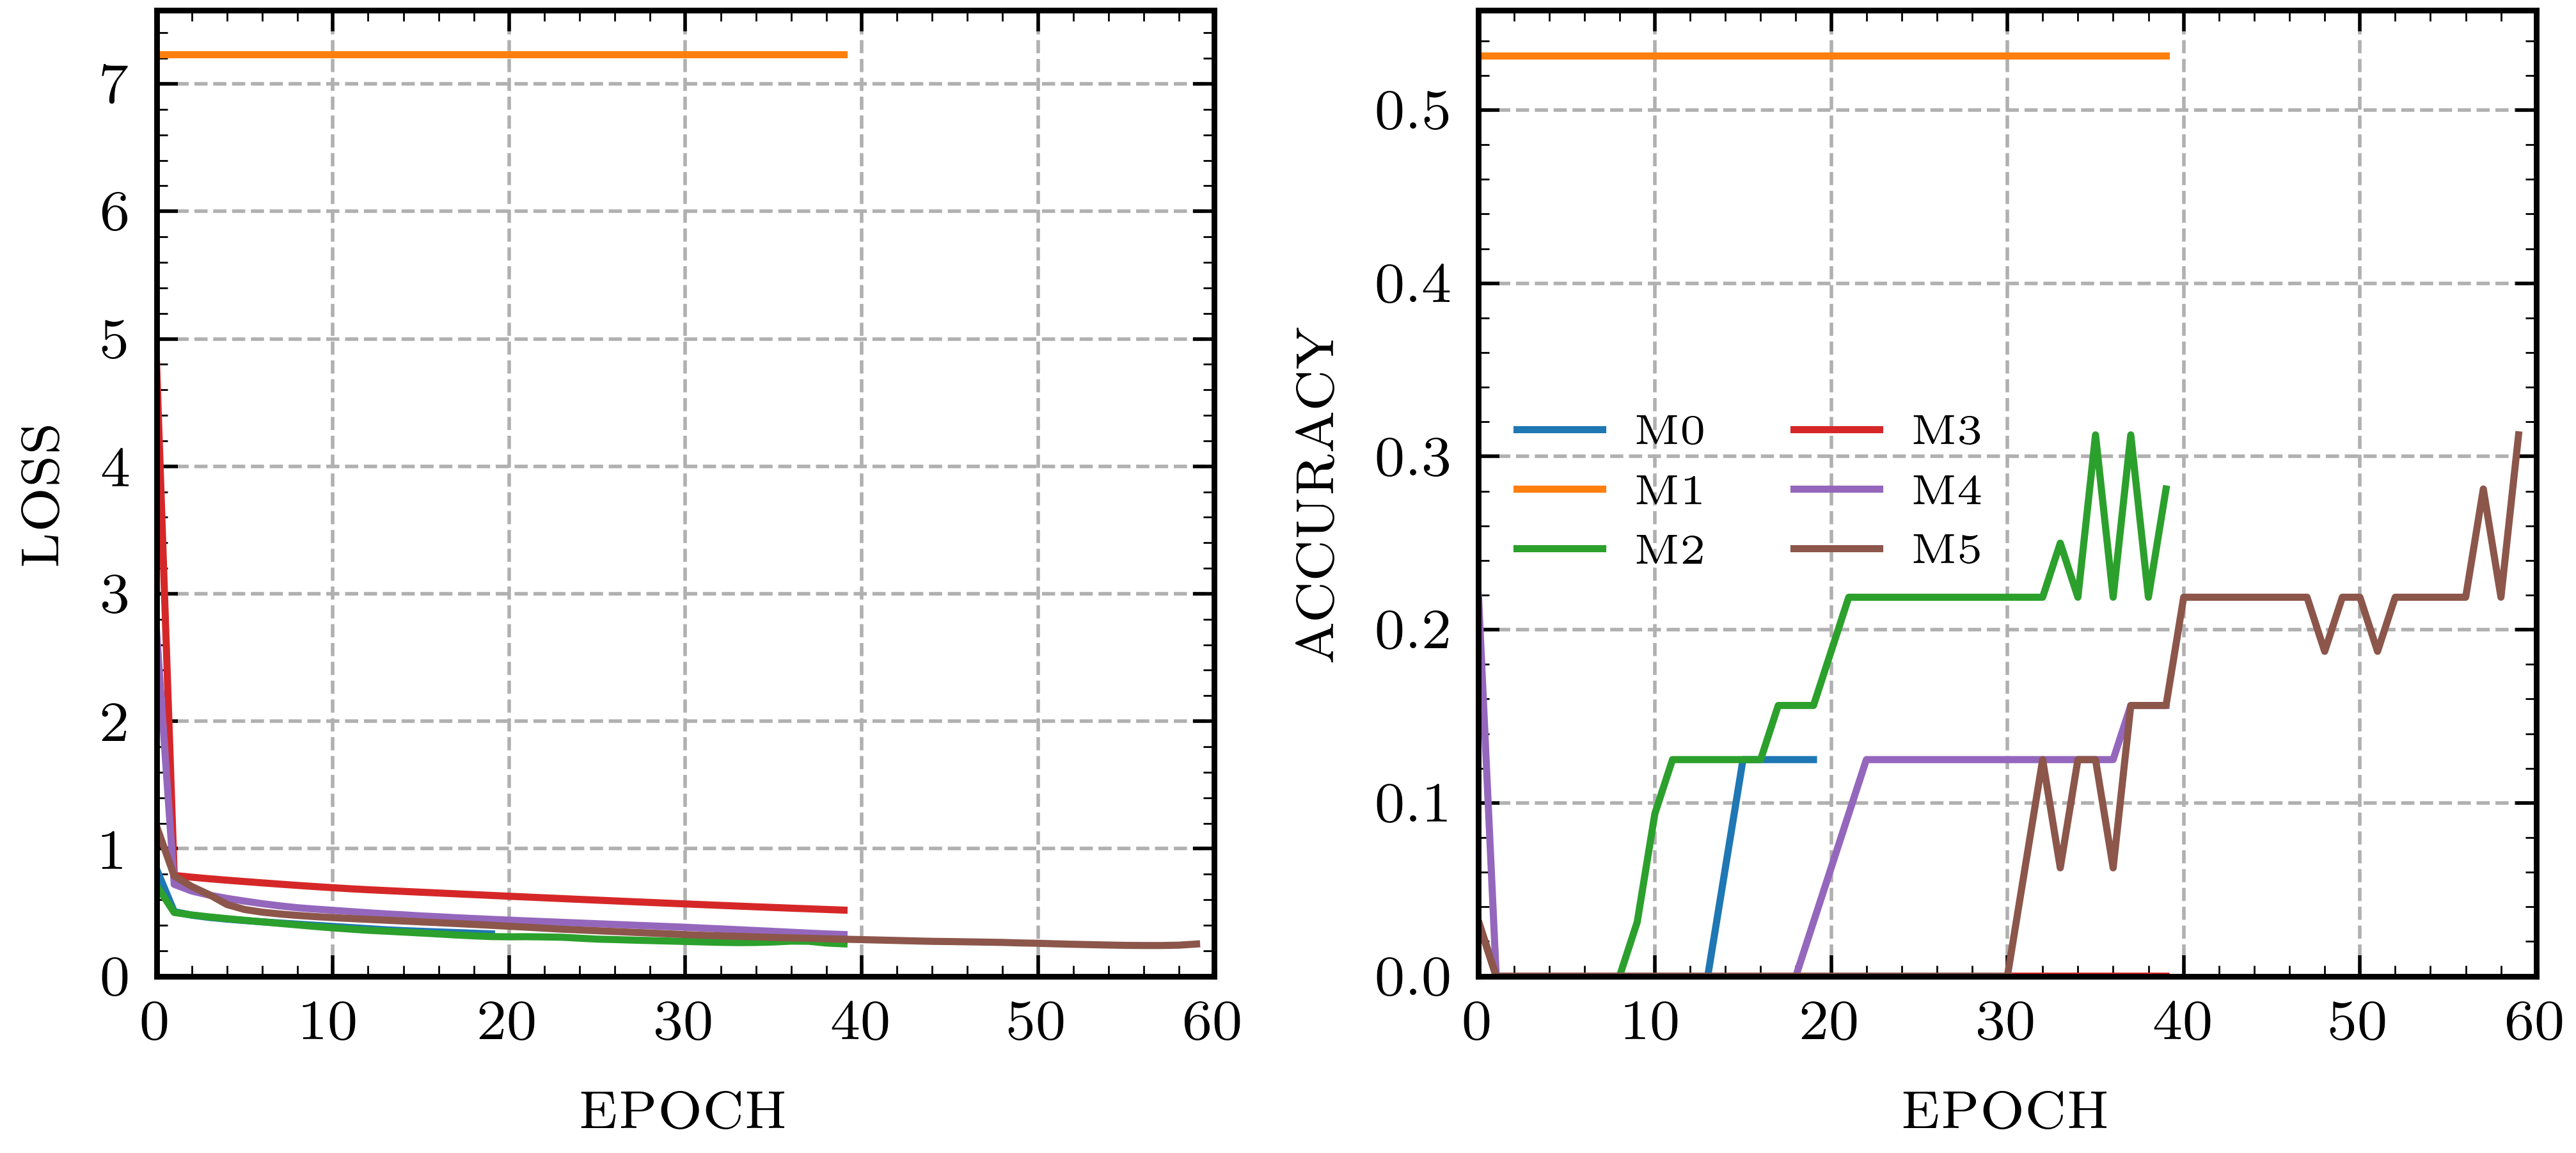

In [130]:
fig = plt.figure(figsize=(6, 2.5), facecolor='white')
gs = fig.add_gridspec(ncols=2, nrows=1, hspace=0, wspace=.25)
axs = gs.subplots(sharex=True, sharey=False)

for ax in axs:
    ax.tick_params(which='both', direction="in")
    ax.set_axisbelow(True)
    ax.grid(True, linestyle='--', lw=.5)
    ax.minorticks_on()
    ax.set_xlabel(r'\textsc{epoch}')
    ax.set_xlim(0, xmax)

# Loss
axs[0].set_ylabel(r'\textsc{loss}')
for i in range(len(models_params.keys())):
    axs[0].plot(histories[i].history['loss'],
                color=models_params[f'm{i}']['COLOR'],
                ls='-', lw=1, label=f'M{i}')
    # axs[0].plot(histories[i].history['val_loss'],
    #             color=models_params[f'm{i}']['COLOR'],
    #             ls='--',  lw=1, label=f'M{i}_ValLoss')

# Accuracy
axs[1].set_ylabel(r'\textsc{accuracy}')
for i in range(len(models_params.keys())):
    axs[1].plot(histories[i].history['accuracy'],
                color=models_params[f'm{i}']['COLOR'],
                ls='-', lw=1, label=f'M{i}')
    # axs[1].plot(histories[i].history['val_accuracy'],
    #             color=models_params[f'm{i}']['COLOR'],
    #             ls='-', lw=1, label=f'M{i}_ValAccuracy')
axs[1].legend(framealpha=0, ncol=2)

for ax in axs:
    ax.set_ylim(0, ax.get_ylim()[1])

fig.savefig('../images/tp1_fig2.pdf')
plt.show()

## Clasificación y validación

In [131]:
y_preds = []
for i in range(len(models_params.keys())):
    y_preds.append(models[i].predict(feats_test))

1/1 [==============================] - 0s 307ms/step


In [132]:
# Assign all values greater than 1 to 1
y_preds = np.array(y_preds)
y_preds[y_preds > 1] = 1.0

In [133]:
cms = []
for i in range(len(models_params.keys())):
    cms.append(confusion_matrix(np.round(y_preds[i]),
                                target_test,
                                labels=[0., 1.]))

In [134]:
# Confusion matrix structure
# TN | FP
# FN | TP

# Print confusion matrices
for i in range(len(models_params.keys())):
    print(f'Model M{i}:')
    for row in cms[i]:
        print('\t\t\t' + ' '.join(map(str, row)))

Model M0:
			4 1
			1 5
Model M1:
			5 6
			0 0
Model M2:
			4 1
			1 5
Model M3:
			5 3
			0 3
Model M4:
			4 1
			1 5
Model M5:
			4 1
			1 5


In [135]:
# print(np.diag(cm).sum() / cm.sum())
for i in range(len(models_params.keys())):
    print(f'Model M{i}:\t', end='')
    print(accuracy_score(target_test, np.round(y_preds[i])))

Model M0:	0.8181818181818182
Model M1:	0.45454545454545453
Model M2:	0.8181818181818182
Model M3:	0.7272727272727273
Model M4:	0.8181818181818182
Model M5:	0.8181818181818182


De los modelos entrenados (los mismos definidos para la primera parte del trabajo), hay cuatro que, aunque tienen parámetros distintos, resultan tener el mismo MSE cuando se los aplica en el set de prueba. Esto puede ser el resultado de los problemas que fueron previamente identificados en los datos.